In [1]:
import os
import warnings
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision

from pathlib import Path
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
import json
import re

from utils import test_model, compare_models_prediction, generate_z_samples
from zoo_utils import load_hyperrep_edx

from shrp.models.def_net import CNN, CNN3
from shrp.models.def_AE_trainable import get_transformations
from shrp.datasets.dataset_auxiliaries import tokens_to_recipe, tokens_to_checkpoint
from shrp.models.def_loss import DistillationLoss, ReconDistillationLoss

/netscratch2/lmeynent/research/structure_vs_behaviour/zoo_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid',
              rc={
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'xtick.bottom': True,
                  'ytick.left': True,
                  'font.family': 'Fira Sans'
              })

COLOURS = [
    '#960018',  # Carmine Red
    '#FED85D',  # Mustard Gold
    '#434384',  # Marian Blue
    '#54B674',  # Emerald Green
    '#D183C9',  # French Mauve
    '#318CE7',  # French Blue
    '#D08000'   # Fulvous Orange
]

## Loading data

In [4]:
RERUN = False

In [5]:
DATASETS = ['svhn', 'cifar10', 'eurosat']
DATASET_LABELS = {
    'svhn': 'SVHN',
    'cifar10': 'CIFAR-10',
    'eurosat': 'EuroSAT'
}

DS_ORDER = ['SVHN', 'CIFAR-10', 'EuroSAT']
HR_ORDER = ['Contrastive + Structure (Baseline)', 'Behavior', 'Contrastive + Behavior', 'Structure + Behavior', 'Contrastive + Structure + Behavior']
HR_PLOT = ['Contrastive + Structure (Baseline)', 'Contrastive + Behavior', 'Contrastive + Structure + Behavior']

EXPERIMENT_PATH = Path.cwd() / 'results' 

In [6]:
# Model zoo train set
TRAINSET_DS = {ds: torch.load(f'/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/{ds}_train_zoo_relu/dataset.pt')['trainset'] for ds in DATASETS}
TRAINSET_DL = {ds: torch.utils.data.DataLoader(TRAINSET_DS[ds], batch_size=64, shuffle=True) for ds in DATASETS}

# Test set corresponding to the data used to train the model zoo
TESTSET_DS = {ds: torch.load(f'/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/{ds}_train_zoo_relu/dataset.pt')['testset'] for ds in DATASETS}
TESTSET_DL = {ds: torch.utils.data.DataLoader(TESTSET_DS[ds], batch_size=64, shuffle=False) for ds in DATASETS}

# Model zoo
ZOO_PATH = {ds: Path(f'/netscratch2/lmeynent/research/structure_vs_behaviour/results/zoos/{ds}_train_zoo_relu') for ds in DATASETS}
ZOO_DS = {ds: torch.load(ZOO_PATH[ds] / 'dataset_test.pt') for ds in DATASETS}
ZOO_DL = {ds: torch.utils.data.DataLoader(ZOO_DS[ds], batch_size=16, shuffle=False) for ds in DATASETS}

ZOO_DS_TRAIN = {ds: torch.load(ZOO_PATH[ds] / 'dataset_train.pt') for ds in DATASETS}
ZOO_DL_TRAIN = {ds: torch.utils.data.DataLoader(ZOO_DS[ds], batch_size=16, shuffle=False) for ds in DATASETS}

# Threshold used to define models that "perform well"; depends on the zoo
MODEL_ACC_THR = {
    'svhn': 0.8,
    'cifar10': 0.6,
    'eurosat': 0.7
}

# Path to the hyper-representation models
HYPERREP_PATH = {ds: Path(f'/netscratch2/lmeynent/research/structure_vs_behaviour/results/hyperrepresentations/tune/{ds}_train_hyperrep') for ds in DATASETS}

In [7]:
X_DIM_1, X_DIM_2 = next(iter(ZOO_DL['svhn']))[0].shape[1:3]
X_COLS = [f'Dimension {i}' for i in range(X_DIM_1 * X_DIM_2)]

Z_DIM_1 = X_DIM_1
Z_DIM_2 = 64
Z_COLS = [f'Dimension {i}' for i in range(Z_DIM_1 * Z_DIM_2)]

In [8]:
MAX_EPOCH = 100

df_hr = pd.DataFrame(columns=[
    'Model zoo',
    'Trial ID',
    'Learning rate',
    'Latent dimension',
    'Behaviour loss',
    'Query set',
    'Query dataset',
    '# of queries',
    'Gamma',
    'Beta',
    'Epoch',
    'Train loss',
    'Train loss (contrast)', 
    'Train loss (recon)',
    'Train loss (structure)', 
    'Train loss (behaviour)',
    'Test loss',
    'Test loss (contrast)', 
    'Test loss (recon)',
    'Test loss (structure)', 
    'Test loss (behaviour)',
    'Dstk: Test accuracy',
    'Dstk: GGap'
])

for ds in tqdm(DATASETS, desc='Loading data', unit='dataset'):
    hr_path = HYPERREP_PATH[ds]
    for path in os.listdir(hr_path):
        if not re.match('AE_trainable', path):
            continue
        path = hr_path / path

        with open(path / 'params.json') as ifh_config, open(path / 'result.json') as ifh_result:
            config = json.load(ifh_config)
            result = pd.read_json(ifh_result, lines=True, dtype={'trial_id': str})

        for edx in range(len(result)):
            df_hr.loc[len(df_hr)] = (
                DATASET_LABELS[ds],
                result.loc[edx]['trial_id'],
                config['optim::lr'],
                config['ae:lat_dim'],
                config['training::loss_distillation'],
                config['training::queryset_distillation'],
                config['training::queryset_dump'],
                config['training::n_queries_distillation'],
                config['training::gamma'],
                config['training::beta'],
                result.loc[edx]['training_iteration'],
                result.loc[edx]['loss/loss_train'],
                result.loc[edx]['loss/loss_contrast_train'],
                result.loc[edx]['loss/loss_recon_train'],
                result.loc[edx]['loss/loss_structure_train'],
                result.loc[edx]['loss/loss_behaviour_train'],
                result.loc[edx]['loss/loss_test'],
                result.loc[edx]['loss/loss_contrast_test'],
                result.loc[edx]['loss/loss_recon_test'],
                result.loc[edx]['loss/loss_structure_test'],
                result.loc[edx]['loss/loss_behaviour_test'],
                result.loc[edx]['dstk/test_acc_test'],
                result.loc[edx]['dstk/ggap_test']
            )

df_hr['Query dataset'] = df_hr['Query dataset'].map({
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/svhn_train_zoo_relu/dataset.pt': 'SVHN',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/cifar10_train_zoo_relu/dataset.pt': 'CIFAR-10',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/eurosat_train_zoo_relu/dataset.pt': 'EuroSAT',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/tinyimagenet_32/dataset.pt': 'TinyImagenet-32'
})
df_hr.head()

Loading data:   0%|          | 0/3 [00:00<?, ?dataset/s]

,Model zoo,Trial ID,Learning rate,Latent dimension,Behaviour loss,Query set,Query dataset,# of queries,Gamma,Beta,...,Train loss (recon),Train loss (structure),Train loss (behaviour),Test loss,Test loss (contrast),Test loss (recon),Test loss (structure),Test loss (behaviour),Dstk: Test accuracy,Dstk: GGap
0,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,1.344194,0.930796,1.390127,1.059503,1.045855,1.060222,0.791913,1.090034,0.559680,0.283559
1,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.275532,0.770928,0.220488,0.257198,0.887651,0.224016,0.591360,0.183200,0.554503,0.276677
2,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.266038,0.677502,0.220320,0.247892,0.708432,0.223653,0.544859,0.187963,0.550643,0.276275
3,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.264123,0.664841,0.219599,0.239949,0.652948,0.218212,0.527920,0.183800,0.551713,0.279411
4,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.261248,0.628665,0.220424,0.242219,0.741064,0.215964,0.495595,0.184894,0.538348,0.282729


In [9]:
IDX_DICT = {ds:
    {
        df_hr[(df_hr['Model zoo'] == DATASET_LABELS[ds]) & (df_hr['Learning rate'] == 1e-4) & (df_hr['Gamma'] == 0.05) & (df_hr['Beta'] == 1.0) & (df_hr['Behaviour loss'] == 'l2')]['Trial ID'].iloc[0]: 'Contrastive + Structure (Baseline)',
        df_hr[(df_hr['Model zoo'] == DATASET_LABELS[ds]) & (df_hr['Learning rate'] == 1e-5) & (df_hr['Gamma'] == 0.05) & (df_hr['Beta'] == 0.1) & (df_hr['Behaviour loss'] == 'l2')]['Trial ID'].iloc[0]: 'Contrastive + Structure + Behavior'
    }
    for ds in DATASETS
}
IDX_DICT

{'svhn': {'50f57_00011': 'Contrastive + Structure (Baseline)',
  '50f57_00008': 'Contrastive + Structure + Behavior'},
 'cifar10': {'0d5ff_00011': 'Contrastive + Structure (Baseline)',
  '0d5ff_00008': 'Contrastive + Structure + Behavior'},
 'eurosat': {'d28cf_00011': 'Contrastive + Structure (Baseline)',
  'd28cf_00008': 'Contrastive + Structure + Behavior'}}

In [10]:
# Loading reference config
trial_id = df_hr.iloc[0]['Trial ID']
for path in os.listdir(HYPERREP_PATH['svhn']):
    if trial_id in path:
        model_path = HYPERREP_PATH['svhn'] / path
        with open(HYPERREP_PATH['svhn'] / path / 'params.json') as ifh:
            ref_config = json.load(ifh)

# Loading reference params
ref_path = ref_config["training::distil_reference"]
with open(os.path.join(ref_path, 'params.json')) as ifh:
    reference_params = json.load(ifh)
    
# Loading reference checkpoint
ref_chkpth = None
for chkpth in os.listdir(ref_path):
    if 'checkpoint_' in chkpth:
        if not ref_chkpth or int(chkpth.split('_')[-1]) > int(ref_chkpth.split('_')[-1]):
            ref_chkpth = chkpth

reference_checkpoint = torch.load(Path(ref_path) / str(ref_chkpth) / 'checkpoints', map_location=torch.device("cpu"))
reference_checkpoint_cuda = {k: v.to('cuda') for k, v in deepcopy(reference_checkpoint).items()}

### Loading hyper-representations

In [11]:
# Loading hyper-reps
def load_hr(trial_id):
    for ds in DATASETS:
        for path in os.listdir(HYPERREP_PATH[ds]):
            if trial_id in path:
                return load_hyperrep_edx(HYPERREP_PATH[ds] / path, MAX_EPOCH)

hyper_reps = {idx: load_hr(idx) for idx in df_hr['Trial ID'].unique()}

### Loading model zoos metadata

In [12]:
DF_ZOO_PATH = EXPERIMENT_PATH / 'zoo_analysis' / 'df_zoo.csv'

df_zoo = pd.read_csv(DF_ZOO_PATH, index_col=0)
df_zoo.head()

,Model zoo,Trial ID,Activation function,Initialisation,Learning rate,Weight decay,Seed,Epoch,Test accuracy,Generalisation gap
0,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,0,0.071758,-0.001563
1,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,1,0.775200,-0.182034
2,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,2,0.829479,-0.016614
3,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,3,0.846381,-0.003682
4,SVHN,7597300394,relu,kaiming_uniform,0.00075,0.0005,6,4,0.848033,0.010410


## Running experiments

Hyper-representation model: `CIFAR-10`\
Models: `SVHN`

In [13]:
EXPERIMENT_PATH = EXPERIMENT_PATH / 'ablation_ft'

if not (EXPERIMENT_PATH).is_dir():
    os.makedirs(EXPERIMENT_PATH)

In [14]:
DF_ZOO_ACC_PATH = EXPERIMENT_PATH / 'df_zoo_acc.csv'
DF_Z_PATH = EXPERIMENT_PATH / 'df_z_dict.csv'
DF_X_PATH = EXPERIMENT_PATH / 'df_x_dict.csv'

X_DIM_1, X_DIM_2 = next(iter(ZOO_DL['svhn']))[0].shape[1:3]
X_COLS = [f'Dimension {i}' for i in range(X_DIM_1 * X_DIM_2)]

Z_DIM_1 = X_DIM_1
Z_DIM_2 = 64
Z_COLS = [f'Dimension {i}' for i in range(Z_DIM_1 * Z_DIM_2)]

if not DF_ZOO_ACC_PATH.is_file() or RERUN:
    # Create dataframe
    df_zoo_acc = pd.DataFrame(columns=['Model index', 'Hyper-representation model', 'Original accuracy', 'Reconstruction accuracy'])
    df_x = pd.DataFrame(columns=['Model index', 'Hyper-representation model'] + X_COLS)
    df_z = pd.DataFrame(columns=['Model index', 'Hyper-representation model'] + Z_COLS)

    # Run experiments
    for bdx, data in enumerate(tqdm(ZOO_DL['cifar10'])):
        x, m, p, _ = data

        for hr_idx, hr_label in IDX_DICT['cifar10'].items():
            z, y, _ = hyper_reps[hr_idx].forward(x, p)
            
            for idx in range(x.shape[0]):
                # Original accuracy
                orig_checkpoint = tokens_to_checkpoint(x[idx], p[idx], reference_checkpoint)
                orig_model = CNN3(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                orig_model.load_state_dict(orig_checkpoint)
                orig_acc = test_model(orig_model, TESTSET_DL['cifar10'])
                
                # Reconstruction accuracy
                recon_checkpoint = tokens_to_checkpoint(y[idx], p[idx], reference_checkpoint)
                recon_model = CNN3(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                recon_model.load_state_dict(recon_checkpoint)
                recon_acc = test_model(recon_model, TESTSET_DL['cifar10'])
                
                # Save results to DataFrame
                mdx = bdx * x.shape[0] + idx
                df_zoo_acc.loc[len(df_zoo_acc)] = (
                    mdx,
                    hr_label,
                    orig_acc,
                    recon_acc
                )
                df_x.loc[len(df_x)] = [mdx, hr_label] + x[idx].flatten().tolist()
                df_z.loc[len(df_z)] = [mdx, hr_label] + z[idx].flatten().tolist()

    # Save results to disk
    df_zoo_acc.to_csv(DF_ZOO_ACC_PATH)
    df_x.to_csv(DF_X_PATH)
    df_z.to_csv(DF_Z_PATH)
    
df_zoo_acc = pd.read_csv(DF_ZOO_ACC_PATH, index_col=0)
df_x = pd.read_csv(DF_X_PATH, index_col=0)
df_z = pd.read_csv(DF_Z_PATH, index_col=0)
df_zoo_acc.head()

  0%|          | 0/45 [00:00<?, ?it/s]

,Model index,Hyper-representation model,Original accuracy,Reconstruction accuracy
0,0,Contrastive + Structure (Baseline),0.1000,0.1001
1,1,Contrastive + Structure (Baseline),0.4288,0.1870
2,2,Contrastive + Structure (Baseline),0.5539,0.2494
3,3,Contrastive + Structure (Baseline),0.6011,0.2562
4,4,Contrastive + Structure (Baseline),0.6644,0.4045


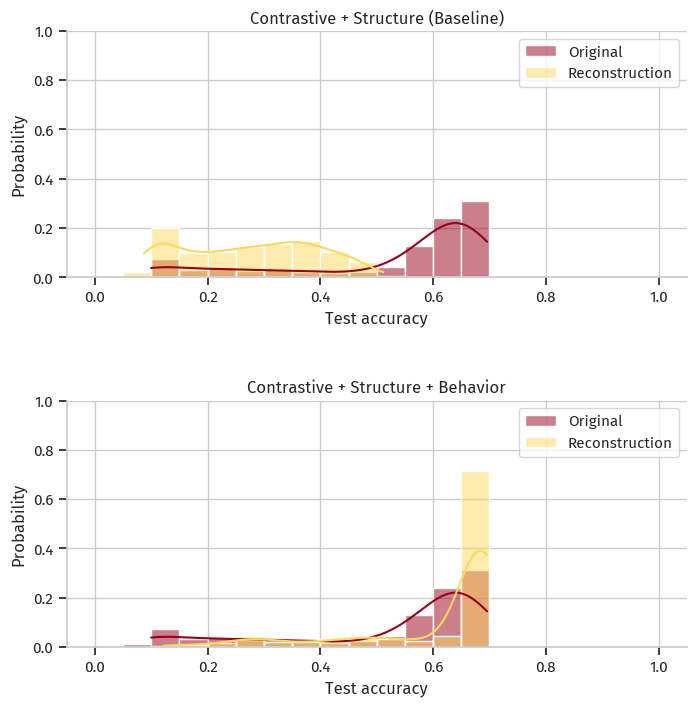

In [15]:
_, axs = plt.subplots(len(IDX_DICT['cifar10']), 1, figsize=(8, 4*len(IDX_DICT['cifar10'])))

for i, (idx, label) in enumerate(IDX_DICT['cifar10'].items()):
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[i])
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstruction', ax=axs[i])
    axs[i].set(title=label, xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
    axs[i].legend()
    
plt.subplots_adjust(hspace=0.5)
plt.show()

### With fine-tuning

In [16]:
from shrp.models.def_loss import ReconDistillationLoss

DF_ZOO_ACC_PATH = EXPERIMENT_PATH / 'df_zoo_ft_acc.csv'
DF_Z_PATH = EXPERIMENT_PATH / 'df_z_ft_dict.csv'
DF_X_PATH = EXPERIMENT_PATH / 'df_x_ft_dict.csv'

N_EPOCHS = 5

if not DF_ZOO_ACC_PATH.is_file() or RERUN:
    # Create dataframe
    df_zoo_acc = pd.DataFrame(columns=['Model index', 'Hyper-representation model', 'Original accuracy', 'Reconstruction accuracy'])
    df_x = pd.DataFrame(columns=['Model index', 'Hyper-representation model'] + X_COLS)
    df_z = pd.DataFrame(columns=['Model index', 'Hyper-representation model'] + Z_COLS)

    # Run experiments
    for hr_idx, hr_label in IDX_DICT['cifar10'].items():
        hr_model = hyper_reps[hr_idx].to('cuda')
        
        trainloader = ZOO_DL_TRAIN['cifar10']
        optimiser = torch.optim.AdamW(hr_model.parameters(), lr=1e-5, weight_decay=3e-9)
        criterion = ReconDistillationLoss(reference_checkpoint, reference_params, queryset='data', dump="/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/svhn_train_zoo_relu/dataset.pt", n_queries=256)
        
        hr_model.train()
        for edx in range(N_EPOCHS):
            for data in trainloader:
                x, m, p, _ = [tensor.to('cuda') for tensor in data]
                
                optimiser.zero_grad()
                _, y, _ = hr_model.forward(x, p)
                loss = criterion(y, x, m, p)
                loss['loss_recon'].backward()
                optimiser.step()
        
        hr_model.eval()
        for bdx, data in enumerate(tqdm(ZOO_DL['cifar10'])):
            x, m, p, _ = [tensor.to('cuda') for tensor in data]
            z, y, _ = hr_model.forward(x, p)
            
            for idx in range(x.shape[0]):
                # Original accuracy
                orig_checkpoint = tokens_to_checkpoint(x[idx], p[idx], reference_checkpoint)
                orig_model = CNN3(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                orig_model.load_state_dict(orig_checkpoint)
                orig_acc = test_model(orig_model, TESTSET_DL['cifar10'])
                
                # Reconstruction accuracy
                recon_checkpoint = tokens_to_checkpoint(y[idx], p[idx], reference_checkpoint)
                recon_model = CNN3(
                    channels_in=reference_params['model::channels_in'],
                    nlin=reference_params['model::nlin'],
                    dropout=reference_params['model::dropout']
                )
                recon_model.load_state_dict(recon_checkpoint)
                recon_acc = test_model(recon_model, TESTSET_DL['cifar10'])
                
                # Save results to DataFrame
                mdx = bdx * x.shape[0] + idx
                df_zoo_acc.loc[len(df_zoo_acc)] = (
                    mdx,
                    hr_label,
                    orig_acc,
                    recon_acc
                )
                df_x.loc[len(df_x)] = [mdx, hr_label] + x[idx].flatten().tolist()
                df_z.loc[len(df_z)] = [mdx, hr_label] + z[idx].flatten().tolist()

    # Save results to disk
    df_zoo_acc.to_csv(DF_ZOO_ACC_PATH)
    df_x.to_csv(DF_X_PATH)
    df_z.to_csv(DF_Z_PATH)
    
df_zoo_acc = pd.read_csv(DF_ZOO_ACC_PATH, index_col=0)
df_x = pd.read_csv(DF_X_PATH, index_col=0)
df_z = pd.read_csv(DF_Z_PATH, index_col=0)
df_zoo_acc.head()

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

,Model index,Hyper-representation model,Original accuracy,Reconstruction accuracy
0,0,Contrastive + Structure (Baseline),0.1000,0.1000
1,1,Contrastive + Structure (Baseline),0.4288,0.1385
2,2,Contrastive + Structure (Baseline),0.5539,0.1345
3,3,Contrastive + Structure (Baseline),0.6011,0.1392
4,4,Contrastive + Structure (Baseline),0.6644,0.3994


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


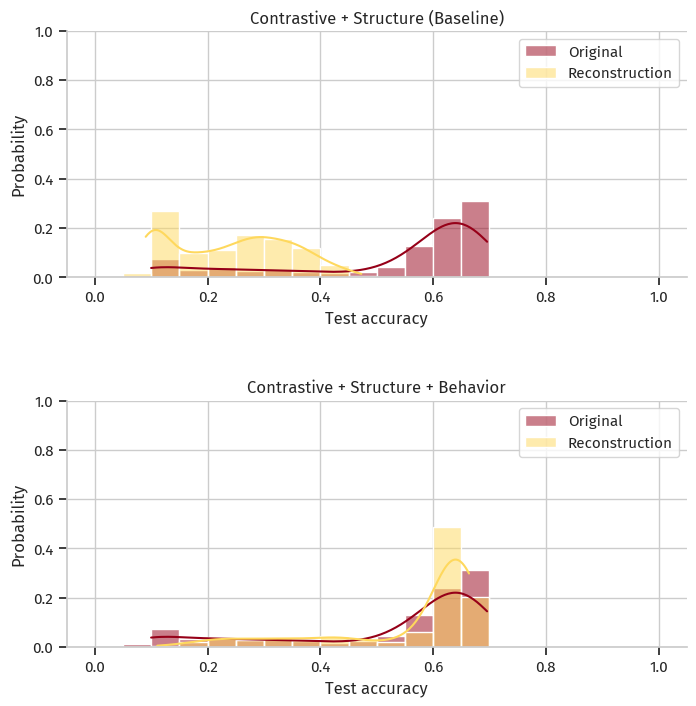

In [17]:
_, axs = plt.subplots(len(IDX_DICT['cifar10']), 1, figsize=(8, 4*len(IDX_DICT['cifar10'])))

for i, (idx, label) in enumerate(IDX_DICT['cifar10'].items()):
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Original accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[0], alpha=0.5, label='Original', ax=axs[i])
    sns.histplot(df_zoo_acc[df_zoo_acc['Hyper-representation model'] == label], x='Reconstruction accuracy', stat='probability', binwidth=0.05, binrange=(0., 1.), kde=True, color=COLOURS[1], alpha=0.5, label='Reconstruction', ax=axs[i])
    axs[i].set(title=label, xlabel='Test accuracy', ylabel='Probability', ylim=(0, 1))
    axs[i].legend()
    
plt.subplots_adjust(hspace=0.5)
plt.show()